*FileName* : Layer normalization  
*Test accuracy* : (52.64%)  
*Train accuracy* : (50.37%)  
*Total params* : 47,660

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/ERA2/session8/'
import model

/content/gdrive/MyDrive/ERA2/session8


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
data = train.data / 255 # data is numpy array

mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


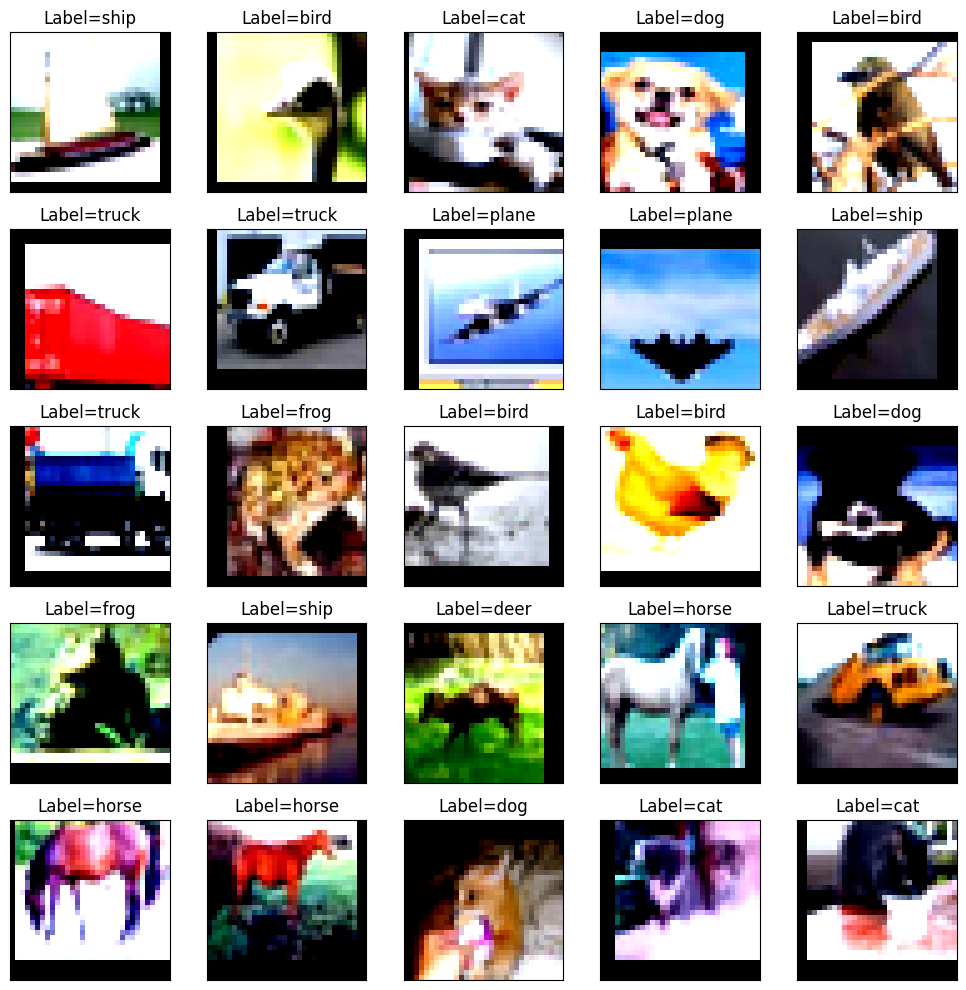

In [8]:
# get some random training images
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
images,labels = next(iter(train_loader))

sample_size=25

images = images[0:sample_size]
labels = labels[0:sample_size]

fig = plt.figure(figsize=(10, 10))

# Show images
for idx in np.arange(len(labels.numpy())):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    # npimg = unnormalize(images[idx])
    # ax.imshow(images[idx], cmap='gray')
    img = images[idx]/2 + 0.5
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))
    plt.imshow(img, cmap='gray', interpolation='none')
    ax.set_title("Label={}".format(str(classes[labels[idx]])))

fig.tight_layout()
plt.show()

In [9]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_S8_LN = model.Model_S8_LN().to(device)
summary(model_S8_LN, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
              ReLU-2           [-1, 16, 30, 30]               0
         LayerNorm-3           [-1, 16, 30, 30]              60
           Dropout-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 20, 30, 30]           2,880
              ReLU-6           [-1, 20, 30, 30]               0
         LayerNorm-7           [-1, 20, 30, 30]              60
           Dropout-8           [-1, 20, 30, 30]               0
            Conv2d-9           [-1, 10, 30, 30]             200
        MaxPool2d-10           [-1, 10, 15, 15]               0
           Conv2d-11           [-1, 16, 15, 15]           1,440
             ReLU-12           [-1, 16, 15, 15]               0
        LayerNorm-13           [-1, 16, 15, 15]              30
          Dropout-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  model.Model_S8_LN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=9, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=2.303711414337158 Batch_id=390 Accuracy=10.53: 100%|██████████| 391/391 [00:23<00:00, 16.34it/s]



Test set: Average loss: 2.2980, Accuracy: 1319/10000 (13.19%)

EPOCH: 1


Loss=2.1011366844177246 Batch_id=390 Accuracy=15.59: 100%|██████████| 391/391 [00:23<00:00, 16.64it/s]



Test set: Average loss: 2.1223, Accuracy: 1947/10000 (19.47%)

EPOCH: 2


Loss=2.0075809955596924 Batch_id=390 Accuracy=23.69: 100%|██████████| 391/391 [00:24<00:00, 15.76it/s]



Test set: Average loss: 1.8695, Accuracy: 2919/10000 (29.19%)

EPOCH: 3


Loss=1.768259048461914 Batch_id=390 Accuracy=30.44: 100%|██████████| 391/391 [00:22<00:00, 17.31it/s]



Test set: Average loss: 1.7541, Accuracy: 3504/10000 (35.04%)

EPOCH: 4


Loss=1.9178825616836548 Batch_id=390 Accuracy=33.79: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]



Test set: Average loss: 1.6901, Accuracy: 3742/10000 (37.42%)

EPOCH: 5


Loss=1.7531096935272217 Batch_id=390 Accuracy=36.65: 100%|██████████| 391/391 [00:23<00:00, 16.55it/s]



Test set: Average loss: 1.6515, Accuracy: 3995/10000 (39.95%)

EPOCH: 6


Loss=1.7748512029647827 Batch_id=390 Accuracy=39.78: 100%|██████████| 391/391 [00:24<00:00, 15.67it/s]



Test set: Average loss: 1.6141, Accuracy: 4040/10000 (40.40%)

EPOCH: 7


Loss=1.3642805814743042 Batch_id=390 Accuracy=42.49: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s]



Test set: Average loss: 1.5466, Accuracy: 4327/10000 (43.27%)

EPOCH: 8


Loss=1.1609241962432861 Batch_id=390 Accuracy=44.59: 100%|██████████| 391/391 [00:24<00:00, 15.70it/s]



Test set: Average loss: 1.4688, Accuracy: 4667/10000 (46.67%)

EPOCH: 9


Loss=1.6171493530273438 Batch_id=390 Accuracy=47.38: 100%|██████████| 391/391 [00:24<00:00, 15.96it/s]



Test set: Average loss: 1.3877, Accuracy: 4924/10000 (49.24%)

EPOCH: 10


Loss=1.5973942279815674 Batch_id=390 Accuracy=47.82: 100%|██████████| 391/391 [00:24<00:00, 16.04it/s]



Test set: Average loss: 1.3943, Accuracy: 4900/10000 (49.00%)

EPOCH: 11


Loss=1.4565647840499878 Batch_id=390 Accuracy=48.49: 100%|██████████| 391/391 [00:24<00:00, 16.12it/s]



Test set: Average loss: 1.3670, Accuracy: 4993/10000 (49.93%)

EPOCH: 12


Loss=1.1616461277008057 Batch_id=390 Accuracy=49.06: 100%|██████████| 391/391 [00:23<00:00, 16.39it/s]



Test set: Average loss: 1.3606, Accuracy: 5016/10000 (50.16%)

EPOCH: 13


Loss=1.4497711658477783 Batch_id=390 Accuracy=48.96: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]



Test set: Average loss: 1.3531, Accuracy: 5064/10000 (50.64%)

EPOCH: 14


Loss=1.3322439193725586 Batch_id=390 Accuracy=49.44: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]



Test set: Average loss: 1.3457, Accuracy: 5089/10000 (50.89%)

EPOCH: 15


Loss=1.3804949522018433 Batch_id=390 Accuracy=49.97: 100%|██████████| 391/391 [00:23<00:00, 16.99it/s]



Test set: Average loss: 1.3315, Accuracy: 5148/10000 (51.48%)

EPOCH: 16


Loss=1.5846575498580933 Batch_id=390 Accuracy=50.04: 100%|██████████| 391/391 [00:24<00:00, 16.00it/s]



Test set: Average loss: 1.3349, Accuracy: 5184/10000 (51.84%)

EPOCH: 17


Loss=1.4092062711715698 Batch_id=390 Accuracy=50.10: 100%|██████████| 391/391 [00:24<00:00, 16.22it/s]



Test set: Average loss: 1.3300, Accuracy: 5194/10000 (51.94%)

EPOCH: 18


Loss=1.2377760410308838 Batch_id=390 Accuracy=50.37: 100%|██████████| 391/391 [00:24<00:00, 16.19it/s]



Test set: Average loss: 1.3189, Accuracy: 5242/10000 (52.42%)

EPOCH: 19


Loss=1.246896743774414 Batch_id=390 Accuracy=50.26: 100%|██████████| 391/391 [00:24<00:00, 16.14it/s]



Test set: Average loss: 1.3180, Accuracy: 5264/10000 (52.64%)



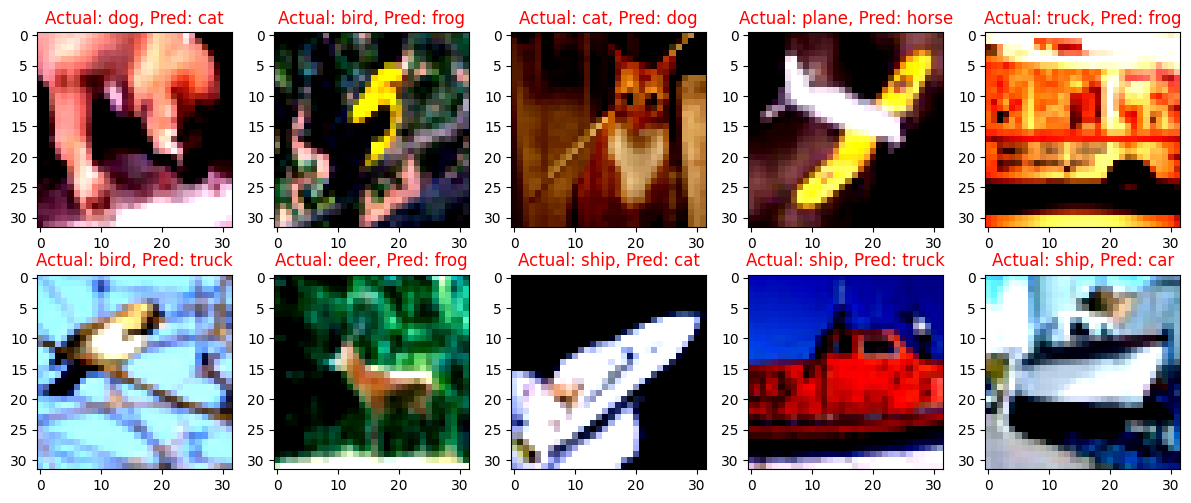

In [12]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model.eval()

misclassified_images = []
actual_labels = []
predicted_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred = torch.max(output, 1)
        for i in range(len(pred)):
            if pred[i] != target[i]:
                misclassified_images.append(data[i])
                actual_labels.append(classes[target[i]])
                predicted_labels.append(classes[pred[i]])

# Plot the misclassified images
fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i+1)
    img = misclassified_images[i].cpu()
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))
    plt.imshow(img, cmap='gray', interpolation='none')
    sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Accuracy')

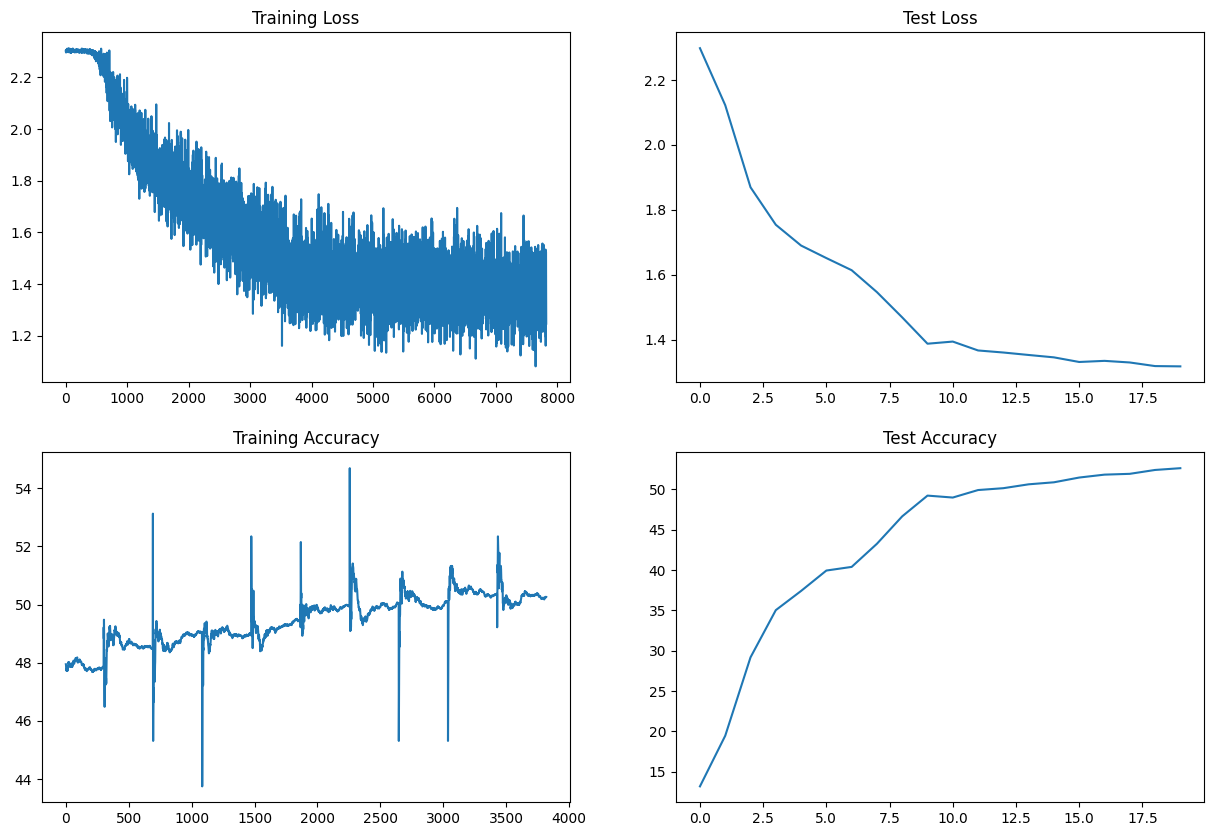

In [13]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")